<a href="https://colab.research.google.com/github/Neelectric/TaD-Labs/blob/main/Text_as_Data_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text as Data Coursework
by Neel Rajani, 2514211r 

*   Note: While answering questions 3-5, I was at times very insecure of whether my code was doing what the assignment was asking for. In addition to asking friends for how they understood questions, I occasionally turned to chatGPT for advice and demonstrations of how some functions work or how to plot things. At times I adapted some of those demonstrations, and at all times rewrote the code shown to me. For example, it suggested hex values of pastel colours to me, or showed me how to print evaluation metrics nicely with pandas dataframs. In complying with University plagiarism rules, I hereby give due credit to chatGPT for supporting my work.

In [62]:
#fix due to this stackoverflow post. https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale
print(locale.getpreferredencoding())

UTF-8


In [63]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [64]:
#small cell due to https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results that disables word wrap
#enabled during report write up to make taking screenshots easier

# from IPython.display import HTML, display

# def set_css():
#   display(HTML('''
#   <style>
#     pre {
#         white-space: pre-wrap;
#     }
#   </style>
#   '''))
# get_ipython().events.register('pre_run_cell', set_css)

#small snippet for pandas to show all columns and rows of dataframes with unlimited width
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 1000)

<ipython-input-64-6354ad2bbf2f>:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [65]:
#import statements
import json
from collections import Counter
import numpy as np
import pandas as pd
import random
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [66]:
#Download data from reddit
!wget -O reddit_posts.json https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1

#load into python
with open('reddit_posts.json', 'rt') as file:
  source = json.load(file)

--2023-03-12 19:27:58--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/EY_R8Y7DkrxMqXGe-zlgeNkBdJU5ZNTf8FYrN2pqDwddMA?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=8ef1d18f92c34cbca9719efb396078d9 [following]
--2023-03-12 19:27:58--  https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=8ef1d18f92c34cbca9719efb396078d9
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1279064 (1.2M) [application/json]
Saving to: ‘reddit_posts.json’

reddit_posts.json   100%[===================>]   1.22M  --.-KB/s    in 0.05s   

2023-03-12 19:27:58 (23.2 

# Q1 - Dataset


In [67]:
labels, texts = [], []
texts = [entry['title'] + '\n' + entry['body'] for entry in source]
labels = [entry['subreddit'] for entry in source]
Counter(labels).most_common()

[('NintendoSwitch', 249),
 ('tea', 236),
 ('Coffee', 234),
 ('PS4', 233),
 ('antiMLM', 226),
 ('pcgaming', 225),
 ('xbox', 213),
 ('HydroHomies', 210),
 ('Soda', 174)]

In [68]:
labels_train_val, labels_test, texts_train_val, texts_test = train_test_split(labels, texts, test_size=0.2, random_state=42)
labels_train, labels_val, texts_train, texts_val = train_test_split(labels_train_val, texts_train_val, test_size=0.25, random_state=42)
print(f"{len(texts_train)=},{len(labels_train)=}")
print(f"{len(texts_val)=},{len(labels_val)=}")
print(f"{len(texts_test)=},{len(labels_test)=}")
total_texts = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total_texts, len(texts_val)/total_texts, len(texts_test)/total_texts

len(texts_train)=1200,len(labels_train)=1200
len(texts_val)=400,len(labels_val)=400
len(texts_test)=400,len(labels_test)=400


(0.6, 0.2, 0.2)

In [69]:
#helper function to apply spacy tokenizer on text
nlp = spacy.load("en_core_web_sm")
def spacyfy(text):
  tokens = []
  doc = nlp(text)
  for t in doc:
    if not t.is_stop and not t.is_punct and not t.is_space:
      tokens.append(t.lemma_.lower())
  return tokens

# Q2: Clustering
What follows is a cell by cell execution of k-means clustering, with k hardcoded to 5 and the full "texts" list chosen as input, as I want to learn about the clustering of the whole dataset, and not only texts_train

In [70]:
def tfidf_vec_scikitlearn_spacy(input):
  vectorizer = TfidfVectorizer(tokenizer = spacyfy)
  return vectorizer.fit_transform(input)

With the aim of getting 5 random centroids to start with, I elected the Forgy partition approach: To randomly select k data points from dataset as initial centroids

In [71]:
random_indices = random.sample(range(0, 1199), 5)
#every time this cell is called, new random numbers are printed. to have some consistency, I decided to copy this output at some point. the output is hardcoded below
random_indices = [1055, 1164, 28, 1136, 618]

In [72]:
#Step 0: Vectorise text
k = 5
tfidf_matrix = tfidf_vec_scikitlearn_spacy(texts)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [73]:
#Step 1: Pick k random "centroids"
centroids = [tfidf_matrix[index] for index in random_indices]
print(len(centroids))

5


The following cell implements k-means clustering, iterating until the model converges or reaches 100 iterations (which it doesn't)

In [74]:
#create dictionary to save closest centroid per text, populate with dummy data
closest_centroid_per_text = {i: [-1,0] for i, _ in enumerate(texts)}

print("start")
converged = False
iterations = 0
while(not converged) & (iterations != 100):
  converged = True
  entries_by_centroid = [[] for i in range(k)]
  print("iteration: " + str(iterations))
  for i in range(len(texts)):
    #Step 2: Assign each vector to its closest centroid
    similarity_list = [centroid.dot(tfidf_matrix[i,:].T)[0,0] for centroid in centroids]
    closest_centroid_index = np.argmax(similarity_list)
    entries_by_centroid[closest_centroid_index].append(tfidf_matrix[i])

    #if the newly calculated closest centroid (and the degree of similarity) differs from the old one, we must update this, and have not yet converged
    if (closest_centroid_per_text[i] != [closest_centroid_index, similarity_list[closest_centroid_index]]):
      converged = False
      closest_centroid_per_text[i] = [closest_centroid_index, similarity_list[closest_centroid_index]]

  #Step 3: Recalculate the centroids based on the closest vectors
  for i in range(k):
      n_matrices = len(entries_by_centroid[i])
      m,n = entries_by_centroid[i][0].shape
      average_matrix = csr_matrix((m,n), dtype=np.float32)
      for matrix in entries_by_centroid[i]:
        average_matrix += matrix
      average_matrix /= n_matrices
      #amend 'centroids' to reflect this
      centroids[i] = average_matrix
  iterations += 1

start
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18


Here I create a list with 5 sublists, where every sublist contains every text inserted into that cluster

In [75]:
texts_by_cluster = []
for i in range(k):
  cluster_size = 0
  cluster_list = []
  for j in range(len(closest_centroid_per_text)):
    if closest_centroid_per_text[j][0] == i:
      cluster_size += 1
      cluster_list.append(j)
  print(cluster_size)
  texts_by_cluster.append(cluster_list)

566
225
442
444
323


Printing every cluster: an example text, the most represented subreddits, and the top 5 tokens with counts

In [76]:
cluster_counters = []
for i in range(len(texts_by_cluster)):
  cluster_dict = {}
  counter = Counter()
  
  print("Cluster " + str(i+1))
  print("Example text:")
  print(texts[texts_by_cluster[i][0]][0:200])
  for j in range(len(texts_by_cluster[i])):
    text_string = spacyfy(texts[texts_by_cluster[i][j]])
    counts = Counter(text_string)
    counter += counts
    if source[texts_by_cluster[i][j]]['subreddit'] in cluster_dict.keys():
      cluster_dict[source[texts_by_cluster[i][j]]['subreddit']] +=1
    else:
      cluster_dict[source[texts_by_cluster[i][j]]['subreddit']] = 1
  size = 0
  for subreddit, count in cluster_dict.items():
    if (count > 10):
      print(f"{subreddit}: {count}")
    size+= count
  cluster_counters.append(cluster_dict)
  print("total size: "+str(size))
  print("counts:")
  print(counter.most_common(5))
  print("\n")

Cluster 1
Example text:
Please help me find this game!
Like 10 or so years ago I loved this game and I can’t remember it now.. 
It was a game show battle Royale thing where all the  contestants killed each other for a prize.
xbox: 45
pcgaming: 165
PS4: 161
NintendoSwitch: 192
total size: 566
counts:
[('game', 1210), ('play', 512), ('like', 307), ('switch', 288), ('look', 172)]


Cluster 2
Example text:
Anyone tried Irn Bru?
It’s a Scottish drink and it’s banned some countries and I was wondering if anyone here has tried it. It has quite a unique taste and it’s not something you’d forget quickly. You
Soda: 158
PS4: 17
HydroHomies: 15
total size: 225
counts:
[('soda', 227), ('find', 111), ('like', 89), ('know', 77), ('try', 71)]


Cluster 3
Example text:
I once had a box of tea that I believe was Scottish Highland black tea. Can anyone recommend me a tea along those lines?
I'd like to repurchase this tea but I cannot find the exact box and don't want 
tea: 222
Coffee: 203
total size: 442

Here I convert the cluster data to a list for our predicted labels. I also had to convert our "labels" list to a numerical representation for the confusion_matrix function to work

In [77]:
labels_predicted = []
for i in range(len(texts)):
  labels_predicted.append(closest_centroid_per_text[i][0])
label_dictionary = {'NintendoSwitch':0,'tea':1,'PS4':2,'Coffee':3,'pcgaming':4,'antiMLM':5,'xbox':6,'HydroHomies':7,'Soda':8}
labels_numerical = [label_dictionary[label] for label in labels]

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

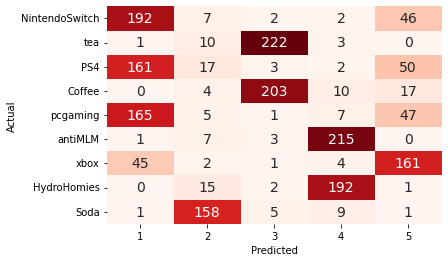

In [78]:
from sklearn.metrics import confusion_matrix
def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  ylabels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
  xlabels = [1,2,3,4,5]
  plot = sn.heatmap(cm[:,:-4], 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 14}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=xlabels, # Put in the X and Y labels
                    yticklabels=ylabels)
  plot.set(xlabel='Predicted', ylabel='Actual')
  return plot

plotConfusionMatrix(labels_numerical, labels_predicted)

# Q3 - Comparing Classifiers

Dummy Classifier with strategy="most_frequent". Most frequent labels in training set are shown below:

In [79]:
Counter(labels_train).most_common()

[('NintendoSwitch', 156),
 ('tea', 149),
 ('PS4', 148),
 ('Coffee', 135),
 ('pcgaming', 134),
 ('antiMLM', 132),
 ('xbox', 125),
 ('HydroHomies', 117),
 ('Soda', 104)]

In [80]:
pd.set_option('display.width', 1000)

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

vectorizer = TfidfVectorizer(tokenizer=spacyfy)
texts_train_tfidf = vectorizer.fit_transform(texts_train)
texts_val_tfidf = vectorizer.transform(texts_val)

dummy_clf_mf = DummyClassifier(strategy="most_frequent")
dummy_clf_mf.fit(texts_train_tfidf, labels_train)

labels_train_predicted = dummy_clf_mf.predict(texts_train_tfidf)
labels_val_predicted = dummy_clf_mf.predict(texts_val_tfidf)

#report = classification_report(labels_val, labels_predicted)
train_accuracy = accuracy_score(labels_train, labels_train_predicted)
train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

val_accuracy = accuracy_score(labels_val, labels_val_predicted)
val_precision = precision_score(labels_val, labels_val_predicted, average='macro')
val_recall = recall_score(labels_val, labels_val_predicted, average='macro')
val_f1 = f1_score(labels_val, labels_val_predicted, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, val_accuracy],
    'Macro Precision': [train_precision, val_precision],
    'Macro Recall': [train_recall, val_recall],
    'Macro F1-score': [train_f1, val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("Dummy Classifier with strategy=\"most_frequent\"")
print(df.round(3))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Dummy Classifier with strategy="most_frequent"
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    0.130     0.014            0.111         0.026         
1                 Validation  0.138     0.015            0.111         0.027         
Best performance  Validation  0.138     0.015            0.111         0.027         


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dummy Classifier with strategy="stratified"

In [81]:
vectorizer = TfidfVectorizer(tokenizer=spacyfy)
texts_train_tfidf = vectorizer.fit_transform(texts_train)
texts_val_tfidf = vectorizer.transform(texts_val)

dummy_clf_mf = DummyClassifier(strategy="stratified")
dummy_clf_mf.fit(texts_train_tfidf, labels_train)

labels_train_predicted = dummy_clf_mf.predict(texts_train_tfidf)
labels_val_predicted = dummy_clf_mf.predict(texts_val_tfidf)

#report = classification_report(labels_val, labels_predicted)
train_accuracy = accuracy_score(labels_train, labels_train_predicted)
train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

val_accuracy = accuracy_score(labels_val, labels_val_predicted)
val_precision = precision_score(labels_val, labels_val_predicted, average='macro')
val_recall = recall_score(labels_val, labels_val_predicted, average='macro')
val_f1 = f1_score(labels_val, labels_val_predicted, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, val_accuracy],
    'Macro Precision': [train_precision, val_precision],
    'Macro Recall': [train_recall, val_recall],
    'Macro F1-score': [train_f1, val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("Dummy Classifier with strategy=\"stratified\"")
print(df.round(3))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Dummy Classifier with strategy="stratified"
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    0.11      0.107            0.108         0.108         
1                 Validation  0.15      0.148            0.151         0.148         
Best performance  Validation  0.15      0.148            0.151         0.148         


LogisticRegression with One-hot vectorization

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
texts_train_oh = vectorizer.fit_transform(texts_train)

texts_val_oh = vectorizer.transform(texts_val)

clf_lr_oh = LogisticRegression()
clf_lr_oh.fit(texts_train_oh, labels_train)

labels_train_predicted = clf_lr_oh.predict(texts_train_oh)
labels_val_predicted = clf_lr_oh.predict(texts_val_oh)

#report = classification_report(labels_val, labels_predicted)
train_accuracy = accuracy_score(labels_train, labels_train_predicted)
train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

val_accuracy = accuracy_score(labels_val, labels_val_predicted)
val_precision = precision_score(labels_val, labels_val_predicted, average='macro')
val_recall = recall_score(labels_val, labels_val_predicted, average='macro')
val_f1 = f1_score(labels_val, labels_val_predicted, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, val_accuracy],
    'Macro Precision': [train_precision, val_precision],
    'Macro Recall': [train_recall, val_recall],
    'Macro F1-score': [train_f1, val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("LogisticRegression with One-hot vectorization")
print(df.round(3))

LogisticRegression with One-hot vectorization
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    1.00      1.000            1.000         1.000         
1                 Validation  0.78      0.794            0.785         0.783         
Best performance  Training    1.00      1.000            1.000         1.000         


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression with TF-IDF vectorization (default settings)

In [83]:
vectorizer = TfidfVectorizer(tokenizer=spacyfy)
texts_train_tfidf = vectorizer.fit_transform(texts_train)
texts_val_tfidf = vectorizer.transform(texts_val)

clf_lr_tfidf = LogisticRegression()
clf_lr_tfidf.fit(texts_train_tfidf, labels_train)

labels_train_predicted = clf_lr_tfidf.predict(texts_train_tfidf)
labels_val_predicted_lrtfidf = clf_lr_tfidf.predict(texts_val_tfidf)

#report = classification_report(labels_val, labels_predicted)
train_accuracy = accuracy_score(labels_train, labels_train_predicted)
train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

val_accuracy = accuracy_score(labels_val, labels_val_predicted_lrtfidf)
val_precision = precision_score(labels_val, labels_val_predicted_lrtfidf, average='macro')
val_recall = recall_score(labels_val, labels_val_predicted_lrtfidf, average='macro')
val_f1 = f1_score(labels_val, labels_val_predicted_lrtfidf, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, val_accuracy],
    'Macro Precision': [train_precision, val_precision],
    'Macro Recall': [train_recall, val_recall],
    'Macro F1-score': [train_f1, val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("LogisticRegression with TF-IDF vectorization (default settings)")
print(df.round(3))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization (default settings)
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    0.988     0.988            0.987         0.988         
1                 Validation  0.832     0.848            0.833         0.834         
Best performance  Training    0.988     0.988            0.987         0.988         


SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)

In [84]:
from sklearn.svm import SVC
vectorizer = CountVectorizer()
texts_train_svc = vectorizer.fit_transform(texts_train)
texts_val_svc = vectorizer.transform(texts_val)

clf_svc = SVC()
clf_svc.fit(texts_train_svc, labels_train)

labels_train_predicted = clf_svc.predict(texts_train_svc)
labels_val_predicted = clf_svc.predict(texts_val_svc)

#report = classification_report(labels_val, labels_predicted)
train_accuracy = accuracy_score(labels_train, labels_train_predicted)
train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

val_accuracy = accuracy_score(labels_val, labels_val_predicted)
val_precision = precision_score(labels_val, labels_val_predicted, average='macro')
val_recall = recall_score(labels_val, labels_val_predicted, average='macro')
val_f1 = f1_score(labels_val, labels_val_predicted, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, val_accuracy],
    'Macro Precision': [train_precision, val_precision],
    'Macro Recall': [train_recall, val_recall],
    'Macro F1-score': [train_f1, val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)")
print(df.round(3))

SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    0.901     0.930            0.900         0.908         
1                 Validation  0.588     0.704            0.598         0.614         
Best performance  Training    0.901     0.930            0.900         0.908         


The classifier with the best performance so far has been LogisticRegression with TF-IDF vectorization on default settings, with a Macro F1-Score of 0.834 on the validation set. Below is code to show a bar chart of F1 scores per class.

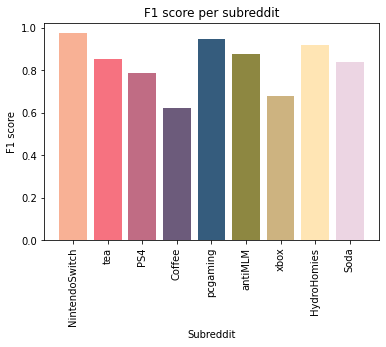

In [85]:
#the pastel colors were suggested by chatGPT
f1_scores_lrtfidf = f1_score(labels_val, labels_val_predicted_lrtfidf, average=None)
subreddits = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
pastel_colors = ['#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D', '#8D8741', '#CDB380', '#FFE5B4', '#ECD5E3']

plt.bar(subreddits, f1_scores_lrtfidf, color=pastel_colors)
plt.title("F1 score per subreddit")
plt.xlabel("Subreddit")
plt.ylabel("F1 score")
plt.xticks(rotation=90)

plt.show()

The approach I myself came up with is shown below: Multinomial Naive Bayes with TF-IDF vectorization

In [86]:
from sklearn.naive_bayes import MultinomialNB
vectorizer = TfidfVectorizer(tokenizer=spacyfy)
texts_train_tfidf = vectorizer.fit_transform(texts_train)
texts_val_tfidf = vectorizer.transform(texts_val)

clf_mnb_tfidf = MultinomialNB()
clf_mnb_tfidf.fit(texts_train_tfidf, labels_train)

labels_train_predicted = clf_mnb_tfidf.predict(texts_train_tfidf)
labels_val_predicted = clf_mnb_tfidf.predict(texts_val_tfidf)

#report = classification_report(labels_val, labels_predicted)
train_accuracy = accuracy_score(labels_train, labels_train_predicted)
train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

val_accuracy = accuracy_score(labels_val, labels_val_predicted)
val_precision = precision_score(labels_val, labels_val_predicted, average='macro')
val_recall = recall_score(labels_val, labels_val_predicted, average='macro')
val_f1 = f1_score(labels_val, labels_val_predicted, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Accuracy': [train_accuracy, val_accuracy],
    'Macro Precision': [train_precision, val_precision],
    'Macro Recall': [train_recall, val_recall],
    'Macro F1-score': [train_f1, val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("Multinomial Naive Bayes with TF-IDF vectorization")
print(df.round(3))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Multinomial Naive Bayes with TF-IDF vectorization
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    0.986     0.987            0.985         0.986         
1                 Validation  0.782     0.832            0.777         0.779         
Best performance  Training    0.986     0.987            0.985         0.986         


# Q4 -  Parameter Tuning

Parameter Tuning of LogisticRegression with TF-IDF vectorisation for both the vectorizer and classifier on the validation set. Tuned Parameters:


1.   Classifier - Regularisation C value (typical values might be powers of 10(from 10^-3 to 10^5)
2.   Vectorizer - Parameters: sublinear_tf and max_features (vocabulary size) (in a range None to 50k)
3.   My own parameter chosen for tuning: Vectorizer - max_df





In [87]:
from sklearn.model_selection import ParameterGrid
#the following comments document values that I investigated during tuning
#c_values = [10**i for i in range(-3, 6)]
#c_values = [i for i in range(1,11)]
#c_values = [1 + i*(3-1)/9 for i in range(10)]
# param_grid = {
#     'sublinear_tf': [True, False], 
#     'max_features': [None, 1000,5000,10000,20000,30000,40000,50000]
#     }
#'max_features': 10000, 'sublinear_tf': True
# param_grid = {
#     'max_df' : [0.1, 0.5, 0.75, 0.9, 1.0]
# }
param_grid = {
    'max_df' : [0.1, 0.2, 0.3, 0.4, 0.5]
}
#for c_value in c_values:
for params in ParameterGrid(param_grid):
  print("\n")
  vectorizer = TfidfVectorizer(tokenizer=spacyfy, sublinear_tf = True, max_features = 10000, max_df = params["max_df"])
  texts_train_tfidf = vectorizer.fit_transform(texts_train)
  texts_val_tfidf = vectorizer.transform(texts_val)

  clf_lr_tfidf = LogisticRegression(C = 1.7)
  clf_lr_tfidf.fit(texts_train_tfidf, labels_train)

  labels_train_predicted = clf_lr_tfidf.predict(texts_train_tfidf)
  labels_val_predicted_lrtfidf = clf_lr_tfidf.predict(texts_val_tfidf)

  #report = classification_report(labels_val, labels_predicted)
  train_accuracy = accuracy_score(labels_train, labels_train_predicted)
  train_precision = precision_score(labels_train, labels_train_predicted, average='macro')
  train_recall = recall_score(labels_train, labels_train_predicted, average='macro')
  train_f1 = f1_score(labels_train, labels_train_predicted, average='macro')

  val_accuracy = accuracy_score(labels_val, labels_val_predicted_lrtfidf)
  val_precision = precision_score(labels_val, labels_val_predicted_lrtfidf, average='macro')
  val_recall = recall_score(labels_val, labels_val_predicted_lrtfidf, average='macro')
  val_f1 = f1_score(labels_val, labels_val_predicted_lrtfidf, average='macro')

  #print evaluation metrics
  #create table of evaluation metrics
  df = pd.DataFrame({
      'Set': ['Validation'],
      'Accuracy': [val_accuracy],
      'Macro Precision': [val_precision],
      'Macro Recall': [val_recall],
      'Macro F1-score': [val_f1]
  })

  #highlight row with best validation performance
  best_val = df.iloc[df['Macro F1-score'].idxmax()]

  #print table to console
  print("LogisticRegression with TF-IDF vectorization " + str(params))
  print(df.round(8))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization {'max_df': 0.1}
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.805     0.812999         0.804349      0.80375       




/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization {'max_df': 0.2}
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.8375    0.851405         0.839209      0.839419      




/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization {'max_df': 0.3}
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.8425    0.854945         0.842807      0.843489      




/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization {'max_df': 0.4}
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.84      0.851644         0.839633      0.840785      




/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization {'max_df': 0.5}
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.84      0.851644         0.839633      0.840785      


#Q5 - Context vectors using BERT

In [88]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
import torch
from transformers import pipeline

pipe = pipeline('feature-extraction', model="roberta-base")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.j

As roberta-base has a maximum sequence length of 512 tokens, and our training set for eg. already contains texts up to 726 tokens long, we must use a function that cuts down strings. 420 is the maximum value that I have found, through trial and error, to let the expanded size of the tensor match the existing size (514) at non-singleton dimension 1.

In [90]:
def ensure_max_length(text_set, max_length):
  constrained_text_set = []
  for text in text_set:
    temp = text.split()
    if len(temp) > max_length:
      temp = temp[:max_length]
    constrained_text = " ".join(temp)
    constrained_text_set.append(constrained_text)
  return constrained_text_set

texts_train_cnstd = ensure_max_length(texts_train, 35)
texts_val_cnstd = ensure_max_length(texts_val, 35)
texts_test_cnstd = ensure_max_length(texts_test, 35)

In [91]:
print(len(texts_train_cnstd[3].split()))

35


In [92]:
# encoded_texts_train = pipe(texts_train_cnstd, return_tensors='pt')
# encoded_texts_val = pipe(texts_val_cnstd, return_tensors='pt')
# encoded_texts_test = pipe(texts_test_cnstd, return_tensors='pt')

In [93]:
from tqdm import tqdm
encoded_texts_train = []
for text in tqdm(texts_train_cnstd):
  output = pipe(text, max_length=512, return_tensors='pt')
  encoded_texts_train.append(output)

100%|██████████| 1200/1200 [04:03<00:00,  4.93it/s]


In [94]:
encoded_texts_val = []
for text in tqdm(texts_val_cnstd):
  output = pipe(text, max_length=512, return_tensors='pt')
  encoded_texts_val.append(output)

100%|██████████| 400/400 [01:22<00:00,  4.85it/s]


In [95]:
encoded_texts_test = []
for text in tqdm(texts_test_cnstd):
  output = pipe(text, max_length=512, return_tensors='pt')
  encoded_texts_test.append(output)

100%|██████████| 400/400 [01:16<00:00,  5.20it/s]


In [96]:
enc_texts_train_st = [text[0][0].numpy() for text in encoded_texts_train]
enc_texts_val_st = [text[0][0].numpy() for text in encoded_texts_val]
enc_texts_test_st = [text[0][0].numpy() for text in encoded_texts_test]

#enc_texts_train_st = [pipe(text)[0][0].numpy() for text in texts_train_cnstd]

In [97]:
# enc_texts_train_st = [text[:,0] for text in encoded_texts_train]
# enc_texts_val_st = [text[:,0] for text in encoded_texts_val]
# enc_texts_test_st = [text[:,0] for text in encoded_texts_test]

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
clf_lr_cv = LogisticRegression(max_iter=1000)
clf_lr_cv.fit(enc_texts_train_st, labels_train)

labels_train_predicted = clf_lr_cv.predict(enc_texts_train_st)
labels_val_predicted = clf_lr_cv.predict(enc_texts_val_st)


#report = classification_report(labels_val, labels_predicted)
parameters = [[labels_train, labels_train_predicted],[labels_val, labels_val_predicted]]
results = []
for parameter_set in parameters:
  accuracy = accuracy_score(parameter_set[0], parameter_set[1])
  precision = precision_score(parameter_set[0], parameter_set[1], average='macro')
  recall = recall_score(parameter_set[0], parameter_set[1], average='macro')
  f1 = f1_score(parameter_set[0], parameter_set[1], average='macro')

  result_list = [accuracy, precision, recall, f1]
  results.append(result_list)

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set':              ['Training', 'Validation'],
    'Accuracy':         [results[0][0], results[1][0]],
    'Macro Precision':  [results[0][1], results[1][1]],
    'Macro Recall':     [results[0][2], results[1][2]],
    'Macro F1-score':   [results[0][3], results[1][3]]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]
best_val.name = 'Best performance'
df = df.append(best_val)

#print table to console
print("LogisticRegression on the first encoded context vector per text using 'feature-extraction' and 'roberta-base'S")
print(df.round(3))

LogisticRegression on the first encoded context vector per text using 'feature-extraction' and 'roberta-base'S
                         Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0                 Training    0.846     0.854            0.848         0.85          
1                 Validation  0.778     0.773            0.771         0.77          
Best performance  Training    0.846     0.854            0.848         0.85          


Next, we train an end-to-end classifier using 'trainer'

In [99]:
learning_rate = 1e-4
batch_size = 16
epochs = 1 
weight_decay = 0.0

In [100]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [101]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/mo

In [102]:
from transformers import AutoConfig, AutoModelForSequenceClassification

config = AutoConfig.from_pretrained("roberta-base", num_labels=9)
model = AutoModelForSequenceClassification.from_config(config)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "n

In [103]:
from sklearn.preprocessing import LabelEncoder
labels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)
encoded_labels_val = label_encoder.fit_transform(labels_val)
encoded_labels_train

array([3, 0, 5, ..., 7, 5, 4])

In [104]:
encoded_texts_train_for_input_ids = tokenizer(texts_train_cnstd, padding=True, truncation=True, return_tensors="pt")
encoded_texts_val_for_input_ids = tokenizer(texts_val_cnstd, padding=True, truncation=True, return_tensors="pt")

input_ids_train = encoded_texts_train_for_input_ids["input_ids"]
input_ids_val = encoded_texts_val_for_input_ids["input_ids"]

In [105]:
print(input_ids_train)

tensor([[    0, 10975,  2709,  ...,     1,     1,     1],
        [    0,   387, 12807,  ...,     1,     1,     1],
        [    0, 28062,  6228,  ...,     1,     1,     1],
        ...,
        [    0, 29042, 25440,  ...,     1,     1,     1],
        [    0,   100,   437,  ...,     1,     1,     1],
        [    0, 42968, 17132,  ...,     1,     1,     1]])


In [106]:
train_dataset_dict = {"input_ids": input_ids_train, "labels": encoded_labels_train}
eval_dataset_dict = {"input_ids": input_ids_val, "labels": encoded_labels_val}
print(len(eval_dataset_dict["labels"]))

400


In [107]:
from datasets import Dataset
train_dataset = Dataset.from_dict(train_dataset_dict)
eval_dataset = Dataset.from_dict(eval_dataset_dict)

In [108]:
print(eval_dataset)

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 400
})


In [109]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=eval_dataset, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

In [110]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1200
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 75
  Number of trainable parameters = 124652553
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,2.195134


***** Running Evaluation *****
  Num examples = 400
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=2.2799652099609373, metrics={'train_runtime': 25.1725, 'train_samples_per_second': 47.671, 'train_steps_per_second': 2.979, 'total_flos': 64137350534400.0, 'train_loss': 2.2799652099609373, 'epoch': 1.0})

In [111]:
predictions, label_ids, metrics = trainer.predict(eval_dataset)

***** Running Prediction *****
  Num examples = 400
  Batch size = 16


In [112]:
print(predictions[0])

[ 0.11704837  0.31202012  0.271253    0.0320636  -0.14343163  0.04907508
  0.30272326  0.01425607  0.00043283]


In [113]:
metrics

{'test_loss': 2.195133686065674,
 'test_runtime': 2.3709,
 'test_samples_per_second': 168.713,
 'test_steps_per_second': 10.545}

In [114]:
predicted_labels = []
for prediction in predictions:
  subreddit_index = np.argmax(prediction)
  subreddit_label = label_encoder.inverse_transform([subreddit_index])[0]
  predicted_labels.append(subreddit_label)

In [115]:
#predicted_labels
Counter(labels_val).most_common()

[('NintendoSwitch', 55),
 ('pcgaming', 51),
 ('antiMLM', 47),
 ('tea', 46),
 ('HydroHomies', 45),
 ('xbox', 43),
 ('Coffee', 40),
 ('Soda', 38),
 ('PS4', 35)]

In [116]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
val_accuracy = accuracy_score(labels_val, predicted_labels)
val_precision = precision_score(labels_val, predicted_labels, average='macro')
val_recall = recall_score(labels_val, predicted_labels, average='macro')
val_f1 = f1_score(labels_val, predicted_labels, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Validation'],
    'Accuracy': [val_accuracy],
    'Macro Precision': [val_precision],
    'Macro Recall': [val_recall],
    'Macro F1-score': [val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]

#print table to console
print("End-to-end classifier using trainer on roberta-base, with learning rate = 1e-4, epochs = 1, batch_size = 16 and no weight decay")
print(df.round(8))

End-to-end classifier using trainer on roberta-base, with learning rate = 1e-4, epochs = 1, batch_size = 16 and no weight decay
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.1125    0.0125           0.111111      0.022472      


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Q5c): Different sets of hyperparameters
Set 1:
learning_rate = 1e-3
batch_size = 32
epochs = 10
weight_decay = 1e-5

Set 2:
learning_rate = 1e-2
batch_size = 64
epochs = 100
weight_decay = 1e-4

In [117]:
learning_rate = 1e-3
batch_size = 32
epochs = 10
weight_decay = 1e-5

training_args = TrainingArguments(
    output_dir="my_awesome_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

config = AutoConfig.from_pretrained("roberta-base", num_labels=9)
model = AutoModelForSequenceClassification.from_config(config)

labels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)
encoded_labels_val = label_encoder.fit_transform(labels_val)
encoded_labels_train

encoded_texts_train_for_input_ids = tokenizer(texts_train_cnstd, padding=True, truncation=True, return_tensors="pt")
encoded_texts_val_for_input_ids = tokenizer(texts_val_cnstd, padding=True, truncation=True, return_tensors="pt")

input_ids_train = encoded_texts_train_for_input_ids["input_ids"]
input_ids_val = encoded_texts_val_for_input_ids["input_ids"]

train_dataset_dict = {"input_ids": input_ids_train, "labels": encoded_labels_train}
eval_dataset_dict = {"input_ids": input_ids_val, "labels": encoded_labels_val}
print(len(eval_dataset_dict["labels"]))

train_dataset = Dataset.from_dict(train_dataset_dict)
eval_dataset = Dataset.from_dict(eval_dataset_dict)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#print(data_collator)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=eval_dataset, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta

400


In [118]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1200
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 380
  Number of trainable parameters = 124652553
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,2.256530
2,No log,2.239929
3,No log,2.283920
4,No log,2.236473
5,No log,2.265020
6,No log,2.234593
7,No log,2.225774
8,No log,2.204735
9,No log,2.213750
10,No log,2.202548


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=380, training_loss=2.287077572471217, metrics={'train_runtime': 228.0923, 'train_samples_per_second': 52.61, 'train_steps_per_second': 1.666, 'total_flos': 641373505344000.0, 'train_loss': 2.287077572471217, 'epoch': 10.0})

In [119]:
predictions, label_ids, metrics = trainer.predict(eval_dataset)
predicted_labels = []
for prediction in predictions:
  subreddit_index = np.argmax(prediction)
  subreddit_label = label_encoder.inverse_transform([subreddit_index])[0]
  predicted_labels.append(subreddit_label)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
val_accuracy = accuracy_score(labels_val, predicted_labels)
val_precision = precision_score(labels_val, predicted_labels, average='macro')
val_recall = recall_score(labels_val, predicted_labels, average='macro')
val_f1 = f1_score(labels_val, predicted_labels, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Validation'],
    'Accuracy': [val_accuracy],
    'Macro Precision': [val_precision],
    'Macro Recall': [val_recall],
    'Macro F1-score': [val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]

#print table to console
print("End-to-end classifier using trainer on roberta-base, with learning_rate = 1e-3, Sbatch_size = 32, epochs = 10, weight_decay = 1e-5")
print(df.round(8))

***** Running Prediction *****
  Num examples = 400
  Batch size = 32


End-to-end classifier using trainer on roberta-base, with learning_rate = 1e-3, Sbatch_size = 32, epochs = 10, weight_decay = 1e-5
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.1375    0.015278         0.111111      0.026862      


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Second set of hyperparameters: 
learning_rate = 1e-2
batch_size = 64
epochs = 10
weight_decay = 1e-4

In [120]:
learning_rate = 1e-2
batch_size = 64
epochs = 100
weight_decay = 1e-4

training_args = TrainingArguments(
    output_dir="my_awesome_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

config = AutoConfig.from_pretrained("roberta-base", num_labels=9)
model = AutoModelForSequenceClassification.from_config(config)

labels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)
encoded_labels_val = label_encoder.fit_transform(labels_val)
encoded_labels_train

encoded_texts_train_for_input_ids = tokenizer(texts_train_cnstd, padding=True, truncation=True, return_tensors="pt")
encoded_texts_val_for_input_ids = tokenizer(texts_val_cnstd, padding=True, truncation=True, return_tensors="pt")

input_ids_train = encoded_texts_train_for_input_ids["input_ids"]
input_ids_val = encoded_texts_val_for_input_ids["input_ids"]

train_dataset_dict = {"input_ids": input_ids_train, "labels": encoded_labels_train}
eval_dataset_dict = {"input_ids": input_ids_val, "labels": encoded_labels_val}
print(len(eval_dataset_dict["labels"]))

train_dataset = Dataset.from_dict(train_dataset_dict)
eval_dataset = Dataset.from_dict(eval_dataset_dict)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#print(data_collator)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=eval_dataset, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta

400


In [121]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1200
  Num Epochs = 100
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1900
  Number of trainable parameters = 124652553
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,4.187460
2,No log,2.705859
3,No log,2.750918
4,No log,2.583448
5,No log,2.555523
6,No log,2.917461
7,No log,2.647347
8,No log,2.786024
9,No log,2.564052
10,No log,2.515482


***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
***** Running Evalua

TrainOutput(global_step=1900, training_loss=2.484320132606908, metrics={'train_runtime': 2154.2145, 'train_samples_per_second': 55.705, 'train_steps_per_second': 0.882, 'total_flos': 6413735053440000.0, 'train_loss': 2.484320132606908, 'epoch': 100.0})

In [122]:
predictions, label_ids, metrics = trainer.predict(eval_dataset)
predicted_labels = []
for prediction in predictions:
  subreddit_index = np.argmax(prediction)
  subreddit_label = label_encoder.inverse_transform([subreddit_index])[0]
  predicted_labels.append(subreddit_label)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
val_accuracy = accuracy_score(labels_val, predicted_labels)
val_precision = precision_score(labels_val, predicted_labels, average='macro')
val_recall = recall_score(labels_val, predicted_labels, average='macro')
val_f1 = f1_score(labels_val, predicted_labels, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Validation'],
    'Accuracy': [val_accuracy],
    'Macro Precision': [val_precision],
    'Macro Recall': [val_recall],
    'Macro F1-score': [val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]

#print table to console
print("End-to-end classifier using trainer on roberta-base, with learning_rate = 1e-2, Sbatch_size = 64, epochs = 100, weight_decay = 1e-4")
print(df.round(8))

***** Running Prediction *****
  Num examples = 400
  Batch size = 64


End-to-end classifier using trainer on roberta-base, with learning_rate = 1e-2, Sbatch_size = 64, epochs = 100, weight_decay = 1e-4
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.1375    0.015278         0.111111      0.026862      


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3rd set if parameters:


In [123]:
learning_rate = 1e-5
batch_size = 32
epochs = 25
weight_decay = 1e-2

training_args = TrainingArguments(
    output_dir="my_awesome_model", # HuggingFace wants a name for your model
    evaluation_strategy="epoch", # How often we want to evaluate the model
    learning_rate=learning_rate, # Hyperparameter
    per_device_train_batch_size=batch_size, # Hyperparameter
    per_device_eval_batch_size=batch_size, # Hyperparameter
    num_train_epochs=epochs, # Hyperparameter
    weight_decay=weight_decay, # Hyperparameter
)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

config = AutoConfig.from_pretrained("roberta-base", num_labels=9)
model = AutoModelForSequenceClassification.from_config(config)

labels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
label_encoder = LabelEncoder()
encoded_labels_train = label_encoder.fit_transform(labels_train)
encoded_labels_val = label_encoder.fit_transform(labels_val)
encoded_labels_train

encoded_texts_train_for_input_ids = tokenizer(texts_train_cnstd, padding=True, truncation=True, return_tensors="pt")
encoded_texts_val_for_input_ids = tokenizer(texts_val_cnstd, padding=True, truncation=True, return_tensors="pt")

input_ids_train = encoded_texts_train_for_input_ids["input_ids"]
input_ids_val = encoded_texts_val_for_input_ids["input_ids"]

train_dataset_dict = {"input_ids": input_ids_train, "labels": encoded_labels_train}
eval_dataset_dict = {"input_ids": input_ids_val, "labels": encoded_labels_val}
print(len(eval_dataset_dict["labels"]))

train_dataset = Dataset.from_dict(train_dataset_dict)
eval_dataset = Dataset.from_dict(eval_dataset_dict)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#print(data_collator)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=train_dataset, # The data to use to update the weights
    eval_dataset=eval_dataset, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/bc2764f8af2e92b6eb5679868df33e224075ca68/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta

400


In [124]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1200
  Num Epochs = 25
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 950
  Number of trainable parameters = 124652553
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,No log,2.202411
2,No log,2.193274
3,No log,2.205780
4,No log,2.217999
5,No log,2.199453
6,No log,2.199346
7,No log,2.193736
8,No log,2.196563
9,No log,2.204711
10,No log,2.180887


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to my_awesome_model/checkpoint-500
Configuration saved in my_aweso

TrainOutput(global_step=950, training_loss=1.7408611096833881, metrics={'train_runtime': 582.0337, 'train_samples_per_second': 51.543, 'train_steps_per_second': 1.632, 'total_flos': 1603433763360000.0, 'train_loss': 1.7408611096833881, 'epoch': 25.0})

In [125]:
predictions, label_ids, metrics = trainer.predict(eval_dataset)
predicted_labels = []
for prediction in predictions:
  subreddit_index = np.argmax(prediction)
  subreddit_label = label_encoder.inverse_transform([subreddit_index])[0]
  predicted_labels.append(subreddit_label)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
val_accuracy = accuracy_score(labels_val, predicted_labels)
val_precision = precision_score(labels_val, predicted_labels, average='macro')
val_recall = recall_score(labels_val, predicted_labels, average='macro')
val_f1 = f1_score(labels_val, predicted_labels, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Validation'],
    'Accuracy': [val_accuracy],
    'Macro Precision': [val_precision],
    'Macro Recall': [val_recall],
    'Macro F1-score': [val_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]

#print table to console
print("End-to-end classifier using trainer on roberta-base, with learning_rate = 1e-5 batch_size = 32 epochs = 25 weight_decay = 1e-2")
print(df.round(8))

***** Running Prediction *****
  Num examples = 400
  Batch size = 32


End-to-end classifier using trainer on roberta-base, with learning_rate = 1e-5 batch_size = 32 epochs = 25 weight_decay = 1e-2
          Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Validation  0.5625    0.579639         0.561818      0.563639      


#Q 6 - Conclusions and Future Work

In [126]:
from sklearn.linear_model import LogisticRegression
vectorizer = TfidfVectorizer(tokenizer=spacyfy, sublinear_tf = True, max_features = 10000, max_df = 0.3)
texts_train_tfidf = vectorizer.fit_transform(texts_train)
texts_test_tfidf = vectorizer.transform(texts_test)

clf_lr_tfidf = LogisticRegression(C = 1.7)
clf_lr_tfidf.fit(texts_train_tfidf, labels_train)

labels_train_predicted = clf_lr_tfidf.predict(texts_train_tfidf)
labels_test_predicted_lrtfidf = clf_lr_tfidf.predict(texts_test_tfidf)

#report = classification_report(labels_val, labels_predicted)

test_accuracy = accuracy_score(labels_test, labels_test_predicted_lrtfidf)
test_precision = precision_score(labels_test, labels_test_predicted_lrtfidf, average='macro')
test_recall = recall_score(labels_test, labels_test_predicted_lrtfidf, average='macro')
test_f1 = f1_score(labels_test, labels_test_predicted_lrtfidf, average='macro')

#print evaluation metrics
#create table of evaluation metrics
df = pd.DataFrame({
    'Set': ['Test'],
    'Accuracy': [test_accuracy],
    'Macro Precision': [test_precision],
    'Macro Recall': [test_recall],
    'Macro F1-score': [test_f1]
})

#highlight row with best validation performance
best_val = df.iloc[df['Macro F1-score'].idxmax()]

#print table to console
print("LogisticRegression with TF-IDF vectorization on the test set with sublinear_tf = True, max_features = 10000, max_df = 0.3, and C = 1.7")
print(df.round(8))

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


LogisticRegression with TF-IDF vectorization on the test set with sublinear_tf = True, max_features = 10000, max_df = 0.3, and C = 1.7
    Set  Accuracy  Macro Precision  Macro Recall  Macro F1-score
0  Test  0.8675    0.869354         0.869186      0.868125      


In [127]:
print(labels_test_predicted_lrtfidf[0])

tea


In [128]:
labels_predicted = []
for i in range(len(texts)):
  labels_predicted.append(closest_centroid_per_text[i][0])
label_dictionary = {'NintendoSwitch':0,'tea':1,'PS4':2,'Coffee':3,'pcgaming':4,'antiMLM':5,'xbox':6,'HydroHomies':7,'Soda':8}
labels_numerical = [label_dictionary[label] for label in labels]

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

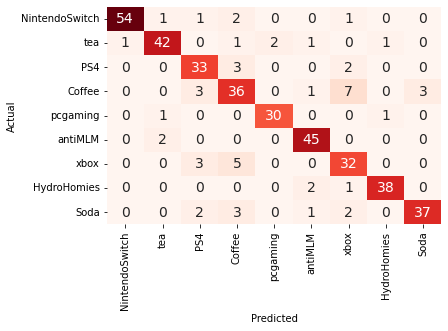

In [129]:
from sklearn.metrics import confusion_matrix
def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  ylabels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
  xlabels = ['NintendoSwitch','tea','PS4','Coffee','pcgaming','antiMLM','xbox','HydroHomies','Soda']
  plot = sn.heatmap(cm[:,:], 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 14}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=xlabels, # Put in the X and Y labels
                    yticklabels=ylabels)
  plot.set(xlabel='Predicted', ylabel='Actual')
  return plot

plotConfusionMatrix(labels_test, labels_test_predicted_lrtfidf)

In [130]:
zipped = zip(labels_test, labels_test_predicted_lrtfidf)
zlist = list(zipped)

In [131]:
fn_coffee = []
for i in range(len(zlist)):
  if (zlist[i][0] == "Coffee") & (zlist[i][1] != "Coffee"):
    fn_coffee.append(i)

In [132]:
print(fn_coffee)
for ix in fn_coffee:
  print(zlist[ix][1])
  print(texts_test[ix])
  print("\n")

[106, 155, 174, 275, 345]
HydroHomies
What drink is the best judge of a cafe?
Obviously answers will vary, but what is your go to drink when trying a new cafe for the first time to see how it stands up? This barista I know says a flat white, so was interested to see what others thought.


PS4
Huge shoutout to /u/suareasy! Sent a free Bodum carafe my way, thanks!
I just wanted to give a public thanks to /u/suareasy for his generosity. He made a post last week offering a French Press carafe and was kind enough to send it my way, no strings attached. 
Pic of carafe next to my Bodum Chambord frame and plunger
Thank you again!


NintendoSwitch
What's the one third wave shop you'd recommend visiting for a two-day trip to Anaheim?
Willing to Uber to any shop outside of Anaheim, as there doesn't appear to be anything worthwhile around the area. What's the one shop you'd recommend me checking out in the surrounding area? The one that I just need to go to. 
I have been to Go Get 'Em Tiger when I